First, it need to preparing the dataset accepted from google drive 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import shutil
shutil.copy("/content/gdrive/MyDrive/Dataset/Underground_Sound_Dataset.zip", "/content/sample_data")

'/content/sample_data/Underground_Sound_Dataset.zip'

In [ ]:
!unzip /content/sample_data/Underground_Sound_Dataset.zip

In [ ]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import IPython.display as ipd
import librosa
import librosa.display

Therefore, it is necessary to check the difference between sound leakage and non-leakage in the process of continuous processing.

In [ ]:
filename='/content/Underground Sound Dataset/Non_Leak Sound/Non_Leak_1.wav'

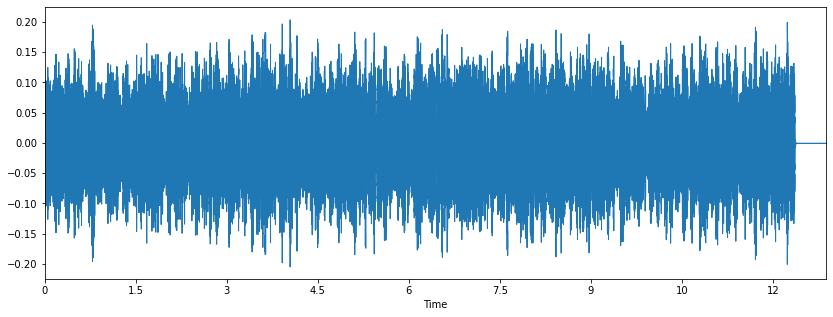

In [ ]:
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)


In [ ]:
sample_rate

22050

In [ ]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio=wav.read(filename)

In [ ]:
wave_sample_rate

8000

In [ ]:
wave_audio

array([1737, 1203,  985, ...,   -3,    1,   -1], dtype=int16)

So all audio is compiled in leaked sound files, all files name and classes are compiled together

In [ ]:
#### Extracting MFCC's For every audio file
import pandas as pd
import os
import librosa
audio_dataset_path='/content/Underground Sound Dataset/Leak Sound'
metadata=pd.read_csv('/content/Underground Sound Dataset/Leak.csv')
metadata.head()

,slice_file_name,classID,class
0,Leak_1.wav,1,Leak Sound
1,Leak_2.wav,1,Leak Sound
2,Non_Leak_1.wav,2,Non_Leak Sound
3,Non_Leak_2.wav,2,Non_Leak Sound
4,Non_Leak_3.wav,2,Non_Leak Sound


# Used the Mel-frequency cepstral coefficients (MFCC) feature extrator to extract the feature 

In [ ]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features   



In [ ]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

5it [00:01,  3.37it/s]


In [ ]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-349.01962, 249.54488, -12.097619, -26.80373,...",Leak Sound
1,"[-309.9076, 258.38406, 10.055078, -13.135408, ...",Leak Sound
2,"[-373.392, 233.93832, -5.568502, -33.878063, -...",Non_Leak Sound
3,"[-305.6522, 199.39928, 11.311145, -25.633247, ...",Non_Leak Sound
4,"[-370.0894, 235.91132, -12.5704775, -27.161833...",Non_Leak Sound


In [ ]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
y

array(['Leak Sound', 'Leak Sound', 'Non_Leak Sound', 'Non_Leak Sound',
       'Non_Leak Sound'], dtype='<U14')

In [ ]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

Build the models 

In [ ]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
### No of classes
num_labels=y.shape[1]


In [ ]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

## The optimizer used the Adam and the loss function used category cross entropy loss

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

Training the models and evaluate the models for the audio recognition

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 27.83628, saving model to saved_models/audio_classification.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 27.8363 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 21.6505 - accuracy: 0.5000
Epoch 2: val_loss improved from 27.83628 to 24.12803, saving model to saved_models/audio_classification.hdf5
1/1 [==============================] - 0s 70ms/step - loss: 21.6505 - accuracy: 0.5000 - val_loss: 24.1280 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 21.8237 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 24.12803 to 21.41558, saving model to saved_models/audio_classification.hdf5
1/1 [==============================] - 0s 66ms/step - loss: 21.8237 - accuracy: 0.0000e+00 - val_loss: 21.4156 - val_acc

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

1.0


In [ ]:
len(X_test)

1

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

1/1 [==============================] - 0s 424ms/step


In [ ]:
predictions

array([[0, 1]], dtype=int32)

## Well, the answer for the testing data was evaluated as Non Leaking Sound

In [ ]:
filename="/content/Underground Sound Dataset/Test Data/test_1.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label= np.argmax(model.predict(mfccs_scaled_features),axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-3.57738678e+02  2.35827042e+02 -7.08881617e-01 -2.27026329e+01
 -7.58915472e+00 -1.76997547e+01  2.56822052e+01  3.35983543e+01
 -5.38249540e+00  3.81444073e+00  1.89460983e+01  7.05598640e+00
  1.44736719e+01  1.57769299e+01 -6.31711960e-01  3.52848554e+00
  8.04093170e+00  4.17742443e+00  1.33080845e+01  7.88750410e+00
 -1.01316748e+01 -3.13433099e+00  5.63428068e+00  2.40678638e-02
  5.76854420e+00  8.23863697e+00 -6.83442020e+00 -1.09076223e+01
 -8.87430251e-01  3.64545655e+00  3.69209051e+00  2.91632724e+00
 -4.89827842e-01 -5.52988100e+00 -8.49539471e+00 -3.79777026e+00
  2.01623702e+00  1.65446788e-01 -1.04568219e+00 -4.48023111e-01]
[[-3.57738678e+02  2.35827042e+02 -7.08881617e-01 -2.27026329e+01
  -7.58915472e+00 -1.76997547e+01  2.56822052e+01  3.35983543e+01
  -5.38249540e+00  3.81444073e+00  1.89460983e+01  7.05598640e+00
   1.44736719e+01  1.57769299e+01 -6.31711960e-01  3.52848554e+00
   8.04093170e+00  4.17742443e+00  1.33080845e+01  7.88750410e+00
  -1.01316748e+01 -

array(['Non_Leak Sound'], dtype='<U14')